In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multilayer perceptron with Scikit-learn

Set a seed for reproducibility:

In [80]:
SEED = 42

In [81]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(SEED)

To create a custom classifier implementation, we need to inherit from the `BaseEstimator` and `ClassifierMixin` classes from the `sklearn.base` module. We also need to implement the `fit` and `predict` methods. The `fit` method should train the model, and the `predict` method should make predictions.

See an example of a custom classifier implementation at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html).

In [82]:
def softmax(z):
    """Softmax function (batch version).

    Args:
        z: the input of the softmax function.
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def sigmoid(z):
    """Sigmoid function (batch version).

    Args:
        z: the input of the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))

def relu(z):
    """ReLU function (batch version).

    Args:
        z: the input of the ReLU function.
    """
    return np.maximum(0, z)

def tanh(z):
    """Tanh function (batch version).

    Args:
        z: the input of the tanh function.
    """
    return np.tanh(z)

def tanh_grad(grad_output, z):
    """Compute the gradient of the loss wrt the output of the tanh function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the tanh function.
        z: the output of the tanh function.
    """
    grad = grad_output * (1 - z ** 2)  # (n, h) * (n, h) => (n, h)
    return grad


def cross_entropy_loss(Y_pred, class_idxs):
    """Compute the cross-entropy loss for a batch of exemplars.

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.
    """
    losses = -np.log(Y_pred[range(len(class_idxs)), class_idxs])
    return np.mean(losses)


def cross_entropy_grad(Y_pred, class_idxs):
    """Compute the gradient of the cross-entropy loss wrt the predicted class probabilities (batch version).

    Args:
        Y_pred: the predicted class probabilities.
        class_idxs: the indices of the true classes.
    """
    grad = -1 / Y_pred[range(len(Y_pred)), class_idxs]  # n,
    grad_output = np.zeros_like(Y_pred)  # (n, k)
    grad_output[range(len(grad_output)), class_idxs] = grad  # (n, k)
    return grad_output  # (n, k)


def softmax_grad(grad_output, Y_pred):
    """Computer the gradient of the loss wrt the logits of the softmax function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the softmax.
        Y_pred: the output of the softmax function.
    """
    grad = np.zeros_like(grad_output)  # (n, k)
    for i in range(len(grad_output)):
        y_pred = Y_pred[i].reshape(-1, 1)  # (k, 1)
        J = np.dot(-y_pred, y_pred.T)  # (k, 1) * (1, k) => (k, k)
        J[np.diag_indices_from(J)] = y_pred.flatten() * (1 - y_pred.flatten())  # (k, k)
        grad[i] = np.dot(grad_output[i], J)  # (k,) @ (k, k) => (k,)
    return grad


def sigmoid_grad(grad_output, s):
    """Compute the gradient of the loss wrt the output of the sigmoid function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the sigmoid function.
        s: the output of the sigmoid function.
    """
    grad = grad_output * s * (1 - s)  # (n, h) * (n, h) => (n, h)
    return grad

def relu_grad(grad_output, X):
    """Compute the gradient of the loss wrt the output of the ReLU function (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the ReLU function.
        X: the input of the ReLU function.
    """
    grad = grad_output.copy()  # (n, h)
    grad[X <= 0] = 0  # (n, h)
    return grad

def linear_gradW(grad_output, X):
    """Compute the gradient of the loss wrt the output of a linear layer (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        X: the input of the linear layer.
    """
    grad = np.dot(X.T, grad_output)  # (d, n) @ (n, h) => (d, h)

    # average over the batch
    grad /= X.shape[0]
    return grad


def linear_gradX(grad_output, W):
    """Compute the gradient of the loss wrt the input of a linear layer (batch version).

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        W: the weights of the linear layer.
    """
    grad = np.dot(grad_output, W.T)  # (n, h) @ (h, d) => (n, d)
    return grad

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_hidden=10, num_epochs=100, lr=0.1, activation='sigmoid'):
        """ Constructor for the MLPClassifier.
        
        Args:
            num_hidden: the number of hidden units.
            num_epochs: the number of training epochs.
            lr: the learning rate.
            activation: the activation function to use ('sigmoid', 'relu', 'tan').
        """
        self.num_hidden = num_hidden
        self.num_epochs = num_epochs
        self.lr = lr

        assert activation in ['sigmoid', 'relu', 'tan']
        
        # Signmoid activation function over a batch of data (default)
        self.activation = sigmoid
        self.activation_grad = sigmoid_grad
        if activation == 'relu':
            self.activation = relu
            self.activation_grad = relu_grad
        elif activation == 'tan':
            self.activation = tanh
            self.activation_grad = tanh_grad

        # Weights
        self.W1 = None
        self.W2 = None

    
    def fit(self, X, y):
        """ Fit the model to the provided data.

        Args:
            X: the input data.
            y: the target labels.
        """

        num_samples = X.shape[0]
        num_features = X.shape[1]
        num_classes = len(np.unique(y))

        # Random weights initialization
        W1 = np.random.randn(num_features + 1, self.num_hidden)
        W2 = np.random.randn(self.num_hidden + 1, num_classes)

        # Add a bias term to the input
        X = np.hstack([X, np.ones((num_samples, 1))])

        # Hidden layer
        h1 = np.ones((num_samples, self.num_hidden + 1))

        # Training loop
        for _ in range(self.num_epochs):
            # Forward pass (prediction)
            z1 = np.dot(X, W1) 
            h1[:, :-1] = self.activation(z1)
            z2 = np.dot(h1, W2) 
            y_pred = softmax(z2)

            # Backward pass
            grad_pred = cross_entropy_grad(y_pred, y)
            grad_z2 = softmax_grad(grad_pred, y_pred)
            grad_W2 = linear_gradW(grad_z2, h1)
            grad_h1 = linear_gradX(grad_z2, W2)
            grad_z1 = self.activation_grad(grad_h1[:, :-1], h1[:, :-1])
            grad_W1 = linear_gradW(grad_z1, X)

            # Update weights
            W1 -= self.lr * grad_W1
            W2 -= self.lr * grad_W2
        
        self.W1 = W1
        self.W2 = W2
        return self

    
    def predict(self, X):
        """ Predict the class labels for the provided data.
        
        Args:
            X: the input data.

        Returns:
            The predicted class labels.
        """
        
        # Forward pass (prediction)
        num_samples = X.shape[0]
        
        # Add a bias term to the input
        X = np.hstack([X, np.ones((num_samples, 1))])

        # Hidden layer
        h1 = np.ones((num_samples, self.num_hidden + 1))
        
        # Forward pass (prediction)
        z1 = np.dot(X, self.W1) 
        h1[:, :-1] = self.activation(z1)
        z2 = np.dot(h1, self.W2) 
        return np.argmax(z2, axis=1)

## Classifying a synthetic dataset

Train set size: 80
Test set size: 20
ymin: 0, ymax: 2


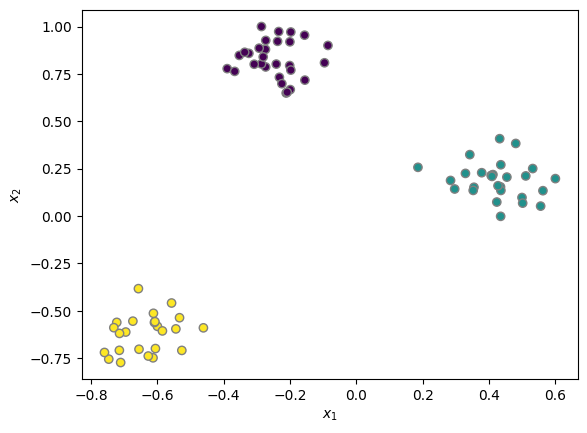

In [84]:
from utils import make_classification_dataset
from sklearn.model_selection import train_test_split

num_classes = 3  # number
X, y = make_classification_dataset(100, 2, num_classes, cluster_std=1)

# Normalize X
X = X / X.max()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="gray")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

print(f"ymin: {y.min()}, ymax: {y.max()}")

Training

In [85]:
clf = MLPClassifier(num_hidden=10, num_epochs=500, lr=1, activation="sigmoid")
clf.fit(X_train, y_train)

MLPClassifier(activation=<function sigmoid at 0x74ed0ef45d80>, lr=1,
              num_epochs=500)

In [86]:
clf.score(X_test, y_test)

1.0

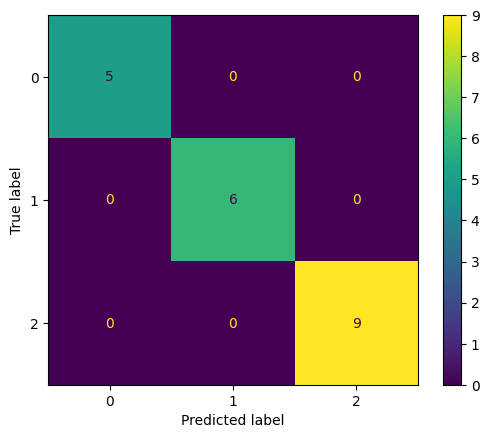


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [87]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Predict the test set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

## Using the scikit-learn library default implementation

For more details, see the MLPClassifier documentation at [this link](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

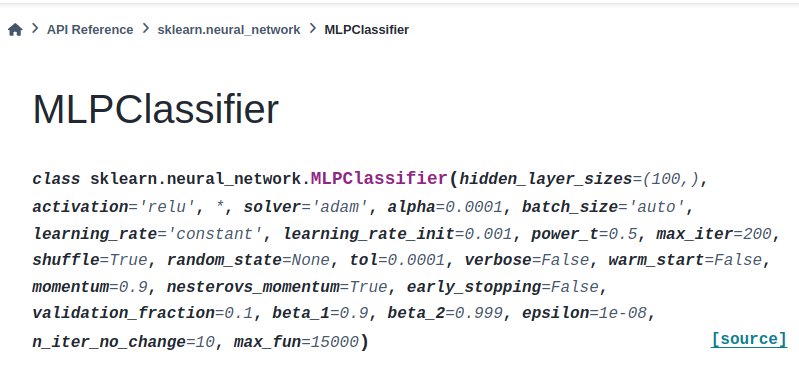

In [88]:
from sklearn.neural_network import MLPClassifier

# batch_size=num_samples means that the weights are updated after each full pass over the training data
num_samples = X_train.shape[0]
clf = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, learning_rate_init=1, batch_size=num_samples, activation='logistic')

### Training

In [89]:
# Not that beautiful, but it works (to illustrate the use of 'return self' in the fit method)
score = clf.fit(X_train, y_train).score(X_test, y_test)
print(f"Test set accuracy: {score}")

Test set accuracy: 1.0


### Test

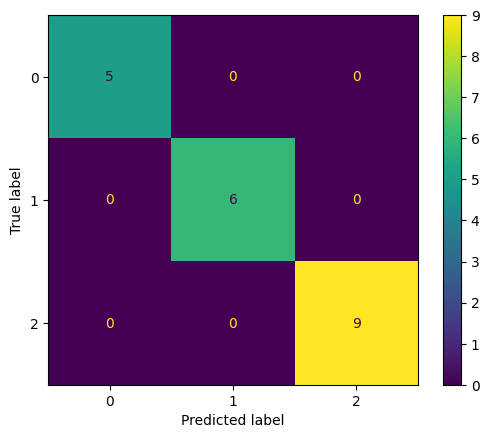


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [90]:
# Predict the test set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

## Case study: Image classification

In this case study, we will use the MNIST dataset to classify handwritten digits. The dataset contains 70,000 images of handwritten digits from 0 to 9. Each image has 28x28 pixels, and each pixel is represented by a value between 0 and 255.

In [91]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = False
FOLDERNAME = None  # only used if TEST_ON_COLAB is True
# FOLDERNAME = "Colab Notebooks/cnn/2_colab-with-drive"

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

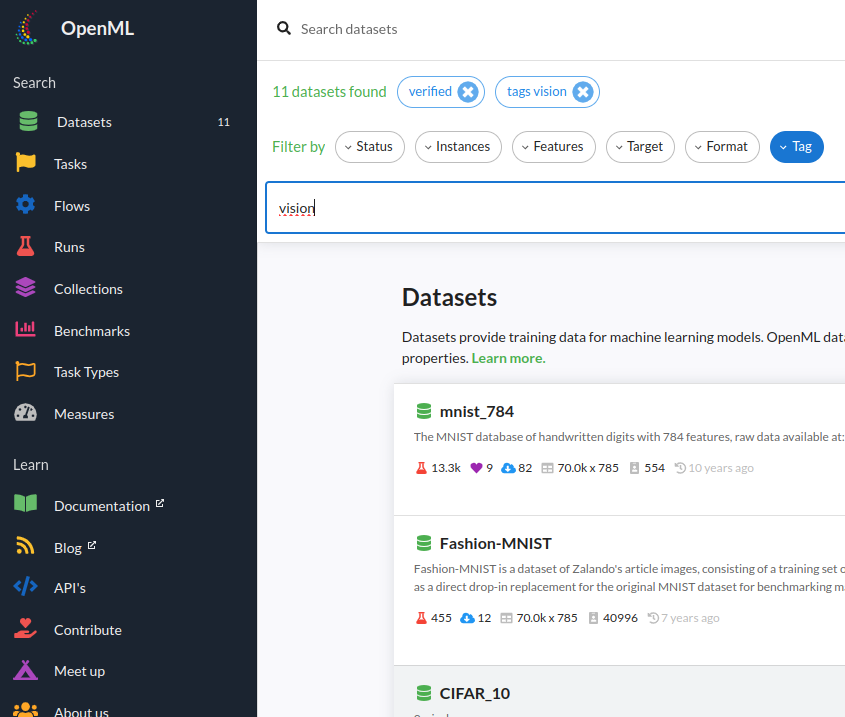

The cell sets the MNIST dataset. You can try with another dataset by changing the `DATASET_OPENM_ID` variable to another dataset ID from the [OpenML platform](https://www.openml.org).

In [92]:
DATASET_OPENML_ID = "mnist_784" # try to use a dataset that is already in the OpenML-CC18 benchmark

assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

Downloading the dataset:

In [93]:
# Create dataset directory
import os

if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET_OPENML_ID}"
else:
    cache_dir = f"dataset/{DATASET_OPENML_ID}"

os.makedirs(cache_dir, exist_ok=True)

# Fetching the dataset
from sklearn.datasets import fetch_openml
import numpy as np

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    # Fetch the dataset where X is the data and y is the target
    X, y = fetch_openml(DATASET_OPENML_ID, as_frame=False, cache=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"{DATASET_OPENML_ID} dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"{DATASET_OPENML_ID} dataset already exists in {cache_dir}. Skipping download.")

print(X.shape)
print(X.min(), X.max())

mnist_784 dataset already exists in dataset/mnist_784. Skipping download.
(70000, 784)
0.0 255.0


Visualizing a few samples from the dataset:

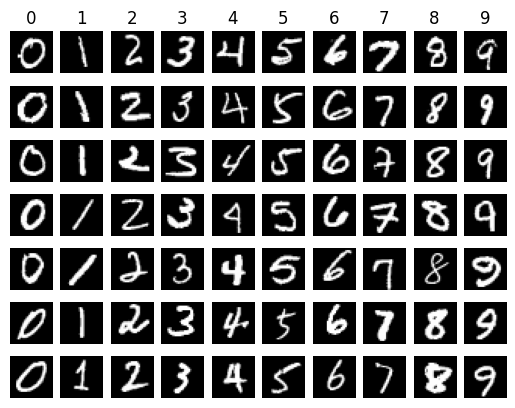

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for cls in classes:
    idxs = np.flatnonzero(y == str(cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].reshape((28, -1)).astype("uint8"), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

Split the dataset into training and test sets:

In [95]:
from sklearn.model_selection import train_test_split

y = y.astype(int)  # convert string labels to integers

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [99]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline that scales the data and trains the MLP classifier
pipeline = Pipeline([
    ("scaler", StandardScaler()), # scale the data to have zero mean and unit variance
    ("mlp", MLPClassifier(hidden_layer_sizes=(10,), max_iter=200, learning_rate_init=0.01, activation="logistic", early_stopping=True)) # batch size is set to auto: min(200, num_samples)
])

In [100]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

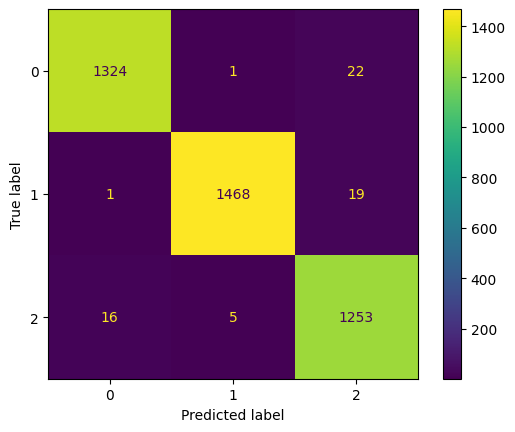


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1390
           1       0.96      0.95      0.96      1541
           2       0.87      0.88      0.87      1421
           3       0.89      0.87      0.88      1453
           4       0.88      0.92      0.90      1319
           5       0.89      0.83      0.86      1261
           6       0.92      0.93      0.93      1405
           7       0.91      0.92      0.91      1477
           8       0.87      0.87      0.87      1413
           9       0.89      0.88      0.88      1320

    accuracy                           0.90     14000
   macro avg       0.90      0.90      0.90     14000
weighted avg       0.90      0.90      0.90     14000



In [101]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### Understanding the report

For multiclass classification, precision and recall are calculated for each class individually, treating the problem as a set of binary classifications (one-vs-rest for each class). Here's how they are computed:

### 1. Precision

$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$
- $TP_i$: True Positives for class $i$ (correctly predicted as class $i$).
- $FP_i$: False Positives for class $i$ (incorrectly predicted as class $i$).

### 2. Recall
Recall for a class is the ratio of correctly predicted positive instances (true positives) to the total actual positive instances (true positives + false negatives).

$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$
- $TP_i$: True Positives for class $i$.
- $FN_i$: False Negatives for class $i$ (actual instances of class $i$ predicted as another class).

### Averaging Methods
Since precision and recall are calculated per class, you can summarize them across all classes using different averaging strategies:

- **Macro Averaging**: Takes the average of precision and recall across all classes equally, without considering the number of instances per class.

$$
\text{Macro Precision} = \frac{1}{C} \sum_{i=1}^{C} \text{Precision}_i
$$

and 

$$
\text{Macro Recall} = \frac{1}{C} \sum_{i=1}^{C} \text{Recall}_i \text{ ,}
$$
where $C$ is the number of classes.

**Micro Averaging**: Computes the global precision and recall by summing up true positives, false positives, and false negatives across all classes and then applying the precision and recall formulas.

$$
\text{Micro Precision} = \frac{\sum_{i=1}^{C} TP_i}{\sum_{i=1}^{C} (TP_i + FP_i)}
$$
$$
\text{Micro Recall} = \frac{\sum_{i=1}^{C} TP_i}{\sum_{i=1}^{C} (TP_i + FN_i)}
$$

**Weighted Averaging**: Similar to macro averaging, but each class's precision and recall are weighted by the number of instances in that class.

These metrics provide a more nuanced understanding of classifier performance in multiclass settings.
